In [1]:
# Import packages
import pandas as pd
import sklearn
import numpy as np
import nltk
import json
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
from codecarbon import EmissionsTracker
experiment_name = "Forecasting"

tracker = EmissionsTracker(
    output_dir="/Users/crystal/Desktop/ANLY5550/codecarbon",
    output_file=f"{experiment_name}_emissions.csv",
    log_level="error",  # comment out this line to see regular output
)
tracker.start()

In [3]:
arlington = pd.read_csv("/Users/crystal/Desktop/ANLY5550/Data/Cleaned/NSRDB_Arlington_cleaned.csv")
net_gen = pd.read_csv("/Users/crystal/Desktop/ANLY5550/Data/Cleaned/EIA_net_generation.csv")

In [4]:
arlington.head(5)

,Date,GHI,Temperature,Cloud Type,Dew Point,Ozone,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed
0,2019-01-01 08:00:00,19,12.6,7,10.6,0.236,87.40,85.22,0.07,1006,1.3,282,5.3
1,2019-01-01 09:00:00,66,12.3,7,9.7,0.238,84.06,76.37,0.07,1008,1.3,288,5.2
2,2019-01-01 10:00:00,54,12.0,6,8.9,0.241,81.25,69.11,0.07,1009,1.2,295,5.3
3,2019-01-01 11:00:00,182,11.4,6,7.9,0.243,79.14,64.10,0.07,1009,1.1,302,5.3
4,2019-01-01 12:00:00,187,11.2,6,7.3,0.247,77.11,61.91,0.07,1009,1.0,305,5.1


In [5]:
net_gen.head(5)

,Date,net_gen_electric_power
0,2017-01-01,15.0
1,2017-02-01,19.0
2,2017-03-01,23.0
3,2017-04-01,25.0
4,2017-05-01,28.0


In [6]:
# Convert 'Date' columns to datetime format
arlington['Date'] = pd.to_datetime(arlington['Date'])
net_gen['Date'] = pd.to_datetime(net_gen['Date'])

# Group the Arlington data by month and calculate the mean of other columns
arlington_monthly = arlington.groupby(arlington['Date'].dt.to_period('M')).mean().reset_index().round(1)

# Group the net generation data by month and calculate the mean of 'net_gen_electric_power'
net_gen_monthly = net_gen.groupby(net_gen['Date'].dt.to_period('M')).mean().reset_index().round(1)

# Merge the datasets on 'Date' column
merged_df = pd.merge(arlington_monthly, net_gen_monthly, on='Date', how='inner')

# Print the merged dataframe
print(merged_df)

       Date    GHI  Temperature  Cloud Type  Dew Point  Ozone  \
0   2019-01  211.4          2.1         3.5       -1.8    0.3   
1   2019-02  293.5          4.5         4.1        0.6    0.3   
2   2019-03  423.8          8.1         3.3        2.3    0.3   
3   2019-04  501.6         17.7         3.7       10.7    0.3   
4   2019-05  543.9         23.0         2.8       16.9    0.3   
5   2019-06  628.8         25.9         2.8       18.4    0.3   
6   2019-07  644.7         30.5         1.6       20.2    0.3   
7   2019-08  560.8         30.3         2.3       17.4    0.3   
8   2019-09  498.3         28.5         2.0       14.5    0.3   
9   2019-10  331.7         20.9         2.4        9.6    0.3   
10  2019-11  260.2          8.9         2.9       -0.1    0.3   
11  2019-12  188.5          5.8         3.5        1.3    0.3   
12  2020-01  216.1          5.7         3.4        0.3    0.3   
13  2020-02  268.5          7.4         3.8        1.0    0.3   
14  2020-03  383.7       

/var/folders/44/9f70kzrs4hd1xjzn2ldh0hqh0000gn/T/ipykernel_50907/2312444669.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  arlington_monthly = arlington.groupby(arlington['Date'].dt.to_period('M')).mean().reset_index().round(1)
/var/folders/44/9f70kzrs4hd1xjzn2ldh0hqh0000gn/T/ipykernel_50907/2312444669.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  net_gen_monthly = net_gen.groupby(net_gen['Date'].dt.to_period('M')).mean().reset_index().round(1)


In [7]:
# save the appended dataframe to the RAW data folder
merged_df.to_csv('/Users/crystal/Desktop/ANLY5550/Data/Cleaned/merged.csv', index=False)

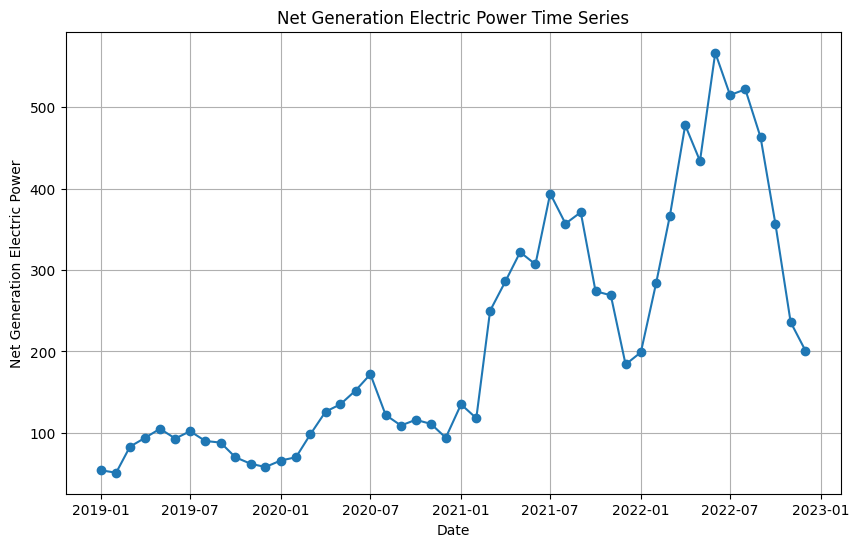

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=383.405, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=385.305, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=385.343, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=382.255, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=383.618, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.108 seconds
Mean Squared Error: 30368.2


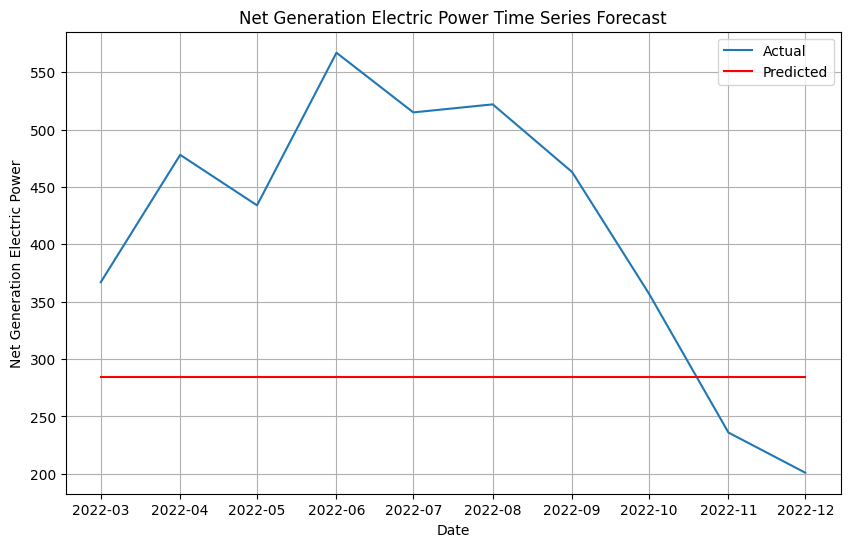

In [8]:
# Convert the data into a pandas DataFrame
df = pd.DataFrame(merged_df)

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'].astype(str))

# Set 'Date' column as index
df.set_index('Date', inplace=True)

# Visualize the data
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['net_gen_electric_power'], marker='o')
plt.title('Net Generation Electric Power Time Series')
plt.xlabel('Date')
plt.ylabel('Net Generation Electric Power')
plt.grid(True)
plt.show()

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Fit the ARIMA model
model = auto_arima(train['net_gen_electric_power'], seasonal=False, trace=True)

# Make predictions
predictions = model.predict(n_periods=len(test))

# Calculate MSE
mse = mean_squared_error(test['net_gen_electric_power'], predictions)
print('Mean Squared Error:', mse)

# Visualize predictions
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['net_gen_electric_power'], label='Actual')
plt.plot(test.index, predictions, color='red', label='Predicted')
plt.title('Net Generation Electric Power Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Net Generation Electric Power')
plt.legend()
plt.grid(True)
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=272.399, Time=0.88 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=262.848, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=265.434, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=265.597, Time=0.05 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=264.033, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=264.063, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=266.030, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=264.087, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=264.228, Time=0.01 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=265.480, Time=0.02 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=264.367, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 1.248 seconds
Mean Squared Error: 9102.19999999979


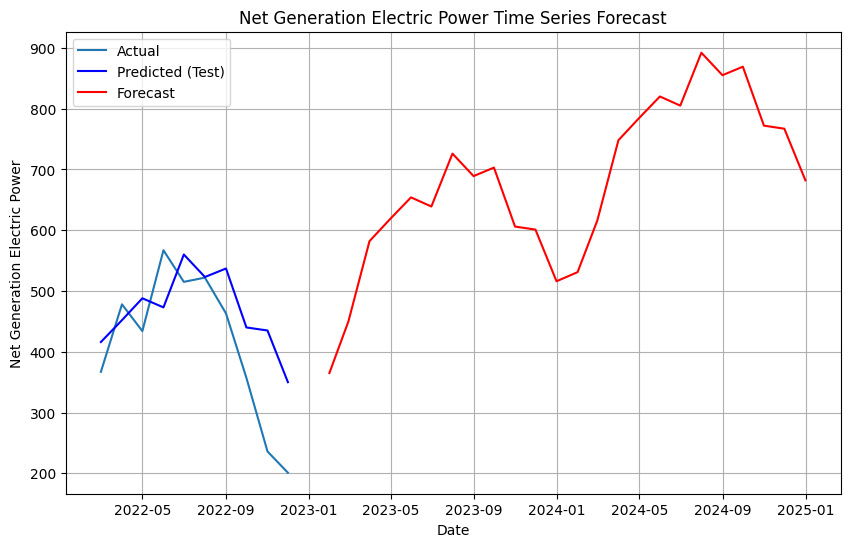

In [9]:
# Fit the seasonal ARIMA model
model = auto_arima(train['net_gen_electric_power'], seasonal=True, m=12, trace=True)

# Define the number of periods for forecasting (until December 2024)
forecast_periods = 24  # Forecasting for 24 months (2025)

# Make predictions
predictions = model.predict(n_periods=len(test) + forecast_periods)

# Extract predictions for the forecast period
forecast_predictions = predictions[-forecast_periods:]

# Calculate MSE for the test period
mse = mean_squared_error(test['net_gen_electric_power'], predictions[:-forecast_periods])
print('Mean Squared Error:', mse)

# Visualize predictions
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['net_gen_electric_power'], label='Actual')
plt.plot(test.index, predictions[:-forecast_periods], color='blue', label='Predicted (Test)')

# Extend the x-axis for the forecast period
forecast_index = pd.date_range(start=test.index[-1], periods=forecast_periods + 1, freq='M')[1:]

# Plot the forecasted values
plt.plot(forecast_index, forecast_predictions, color='red', label='Forecast')

plt.title('Net Generation Electric Power Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Net Generation Electric Power')
plt.legend()
plt.grid(True)

# Save the plot as a PNG file
plt.savefig('/Users/crystal/Desktop/ANLY5550/Visualization/forecast_net_gen.png')

plt.show()



/var/folders/44/9f70kzrs4hd1xjzn2ldh0hqh0000gn/T/ipykernel_50907/4007501163.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])
/var/folders/44/9f70kzrs4hd1xjzn2ldh0hqh0000gn/T/ipykernel_50907/4007501163.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_monthly = data.groupby(data['Date'].dt.to_period('M')).mean().reset_index()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=272.399, Time=0.54 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=262.848, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=265.434, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=265.597, Time=0.06 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=264.033, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=264.063, Time=0.02 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=266.030, Time=0.05 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=264.087, Time=0.01 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=264.228, Time=0.02 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=265.480, Time=0.02 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=264.367, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.815 seconds
Mean Squared Error: 9102.19999999979


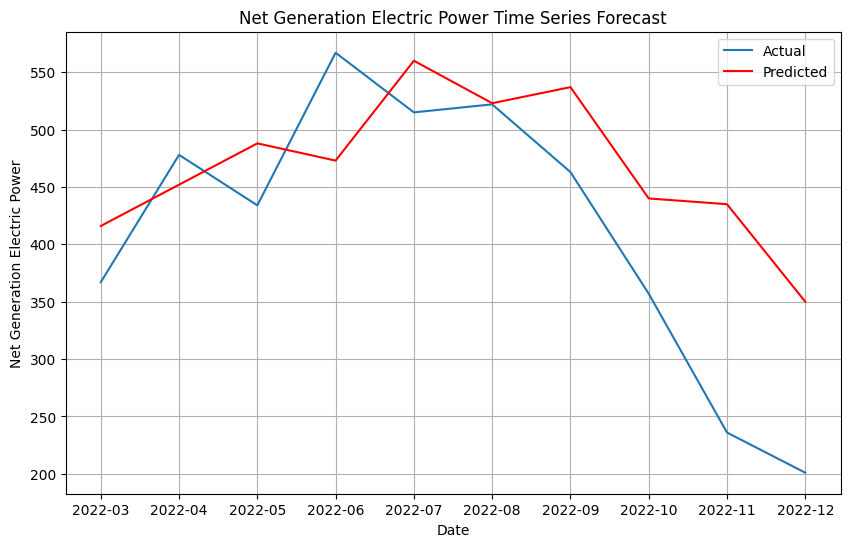

In [10]:
# Select relevant columns
data = merged_df[['Date', 'Solar Zenith Angle', 'Cloud Type', 'Relative Humidity', 'GHI', 'net_gen_electric_power']]

# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Group the data by month and calculate the mean of other columns
data_monthly = data.groupby(data['Date'].dt.to_period('M')).mean().reset_index()

# Split the data into train and test sets
train_size = int(len(data_monthly) * 0.8)
train, test = data_monthly[:train_size], data_monthly[train_size:]

# Fit the seasonal ARIMA model
model = auto_arima(train['net_gen_electric_power'], exogenous=train[['Solar Zenith Angle', 'Cloud Type', 'Relative Humidity', 'GHI']], seasonal=True, m=12, trace=True)

# Make predictions
predictions = model.predict(n_periods=len(test), exogenous=test[['Solar Zenith Angle', 'Cloud Type', 'Relative Humidity', 'GHI']])

# Calculate MSE
mse = mean_squared_error(test['net_gen_electric_power'], predictions)
print('Mean Squared Error:', mse)

# Visualize predictions
plt.figure(figsize=(10, 6))
plt.plot(test['Date'].astype(str), test['net_gen_electric_power'], label='Actual')
plt.plot(test['Date'].astype(str), predictions, color='red', label='Predicted')
plt.title('Net Generation Electric Power Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Net Generation Electric Power')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
tracker.stop()

1.0734165073333001e-05